# Classification examples based on Chapter 4 of "Hands-on Machine Learning with scikit-learn and TensorFlow" by Aurélien Géron

First define some plotting parameters:

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Bitstream Vera Sans']
rcParams['font.serif'] = ['Bitstream Vera Sans']
rcParams["font.size"] = "16"

### Read MNIST data using Keras

In [2]:
import numpy as np
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()
# Transform images to vectors for these examples
X_train, X_test = X_train.reshape(-1, 28*28), X_test.reshape(-1, 28*28)

/Users/ksaaskil/.pyenv/versions/3.5.0/envs/python3.5.0/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Read training and test data and shuffle training set just in case

In [3]:
print('Shape of X_train:', X_train.shape)
print('Shape of y_train:', y_train.shape)

from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train, random_state=42)

Shape of X_train: (60000, 784)
Shape of y_train: (60000,)


### Plot one of the images

/Users/ksaaskil/.pyenv/versions/3.5.0/envs/python3.5.0/lib/python3.5/site-packages/matplotlib/font_manager.py:1339: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


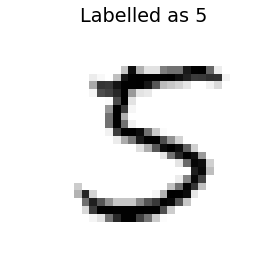

In [4]:
# Pick the first five
digit_index = next(index for index, label in enumerate(y_train) if label == 5)
digit_image = X_train[digit_index].reshape(28, 28)

digit_label = y_train[digit_index]

plt.imshow(digit_image, cmap=matplotlib.cm.binary, interpolation="nearest")
plt.axis('off')
plt.title('Labelled as %d' % digit_label)
plt.show()

## Binary classification
### Do binary classification trying to classify images as "5 or "not a 5"

In [5]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

### Use a simple `SGDClassifier`

In [6]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(loss='log', random_state=42, max_iter=1000, tol=1e-3)

sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', max_iter=1000, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=0.001, verbose=0, warm_start=False)

See if the image labelled as five is classified as a five:

In [7]:
sgd_clf.predict([X_train[digit_index]])

array([ True])

### Evaluate performance with 5-fold cross validation using accuracy as scoring

In [9]:
from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(sgd_clf, X_train, y_train_5, cv=5, scoring="accuracy")
print('Got mean accuracy %.2f with std of %.2f' % (np.mean(cv_scores), np.std(cv_scores)))

Got mean accuracy 0.96 with std of 0.00


### Compare to silly "not 5" estimator that also gets 90% accuracy

In [11]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((X.shape[0], 1), dtype=bool)
never_5_clf = Never5Classifier()
cv_scores_2 = cross_val_score(never_5_clf, X_train, y_train_5, cv=5, scoring="accuracy")
print('Got mean accuracy %.2f with std of %.2f' % (np.mean(cv_scores_2), np.std(cv_scores_2)))

Got mean accuracy 0.91 with std of 0.00


### It seems that accuracy is not that good a metric for a skewed dataset with lots of "not 5":s, so let's look at confusion matrix instead. First compute predictions for all images in the training set:

In [13]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=5)

### Then compute the confusion matrix. The values go like this:
<table>
  <tr>
     <th>true negatives for not 5</th>
     <th>false positives for not 5</th> 
  </tr>
  <tr>
     <th>false negatives for a 5</th>
     <th>true positives for a 5</th> 
  </tr>
</table>
or generally for binary classifier
<table>
  <tr>
     <th>Class 0 predicted as 0</th>
     <th>Class 0 predicted as 1</th> 
  </tr>
  <tr>
     <th>Class 1 predicted as 0</th>
     <th>Class 1 predicted as 1</th> 
  </tr>
</table>

In [14]:
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y_train_5, y_train_pred)
cf_matrix

array([[54082,   497],
       [ 1611,  3810]])

### Compute precision and recall defined as 
$$ precision = \frac{TP}{TP + FP} $$
and 
$$ recall = \frac{TP}{TP + FN} $$
- Precision depicts the probability that an image predicted to be a five actually was a five.
- Recall is the probability that an image labelled as five was correctly predicted to be a five (true positive rate)

The harmonic mean of precision and recall is the $F_1$ score:
$$ F_1 = \frac{2}{\frac{1}{precision} + \frac{1}{recall}} $$

In [15]:
from sklearn.metrics import precision_score, recall_score, f1_score

def print_metrics(y_train, y_pred):
    print('Got precision %.2f' % (precision_score(y_train, y_pred)))
    print('Got recall %.2f' % (recall_score(y_train, y_pred)))
    print('Got F1 score %.2f' % (f1_score(y_train, y_pred)))
print_metrics(y_train_5, y_train_pred)

Got precision 0.88
Got recall 0.70
Got F1 score 0.78


### One can tune the precision-recall tradeoff by tuning the decision boundary threshold. While this cannot be set for `SGDClassifier` directly, one can access the decision function and classify using a threshold. Increasing the threshold increases precision, as classifier classifies less images as fives. It reduces the recall, as more fives are missed.

In [19]:
class SGDClassifierWithThreshold(BaseEstimator):
    def __init__(self, sgd_clf, threshold):
        self.threshold = threshold
        self.sgd_clf = sgd_clf
        # super().__init__()
    def fit(self, X, y=None):
        self.sgd_clf.fit(X, y)
        return self
    def predict(self, X):
        return self.sgd_clf.decision_function(X) > self.threshold

sgd_with_threshold = SGDClassifierWithThreshold(sgd_clf=SGDClassifier(max_iter=1000, tol=1e-3), threshold=3)
y_train_pred = cross_val_predict(sgd_with_threshold, X_train, y_train_5, cv=5)
print_metrics(y_train_5, y_train_pred)

Got precision 0.69
Got recall 0.73
Got F1 score 0.71


### One can plot the precision-recall curve straightforwardly by computing the decision function values for all training instances

In [20]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=5, method='decision_function')
y_scores

array([-54300.46398128, -43825.04552167, -36657.16552377, ...,
       -67259.58560417, -98141.5807993 , -50394.96047075])

In [21]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

### Plot the precision-recall curve

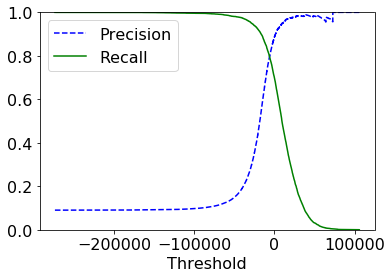

In [22]:
def plot_precision_recall_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
    plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
    plt.xlabel('Threshold')
    plt.legend()
    plt.ylim([0, 1])
    # plt.xlim([-10, 10])
    
plot_precision_recall_threshold(precisions, recalls, thresholds)

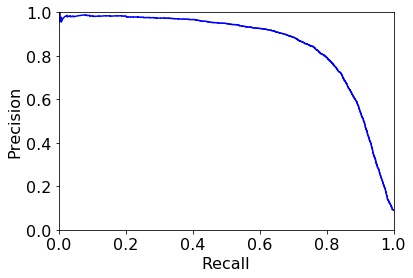

In [23]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, 'b-', label='Precision-recall')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.axis([0, 1, 0, 1])
    
plot_precision_vs_recall(precisions, recalls)

### The ROC curve
Another metric useful for binary classification is the _receiver operating characteristic_ (ROC) curve. It plots the _true positive rate_ (recall) versus the false positive rate (FPR). FPR is the ratio of negative instances that are incorrectly classified as positive. Here are the definitions again:
$$
TPR \ (recall) = \frac{TP}{TP + FN}
$$
and 
$$
FPR = \frac{FP}{FP + TN}
$$ 

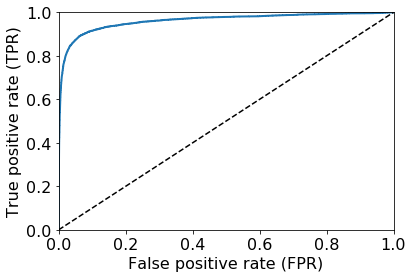

In [24]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False positive rate (FPR)')
    plt.ylabel('True positive rate (TPR)')

plot_roc_curve(fpr, tpr)
plt.show()

One way to compare classifiers is the _area under curve_ (AUC). A perfect classifier has AUC equal to 1, whereas purely random classifier will have AUC equal to 0.5. ROC AUC can be computed directly with sklearn:

In [25]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9616301749496309

ROC curve can be misleading if the positive class is rare, like in this case. Precision-recall curve can be more informative also in the case when false positives are more important than false negatives.

To compare classifiers, let us train a _RandomForestClassifier_.

In [26]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)

# Return class probabilities as decision tree does not have decision scores
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=5, method="predict_proba")

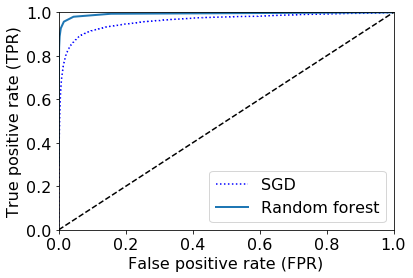

In [27]:
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random forest")
plt.legend(loc="lower right")
plt.show()

Also the AUC score is much better for the random forest:

In [28]:
roc_auc_score(y_train_5, y_scores_forest)

0.9934705259567339

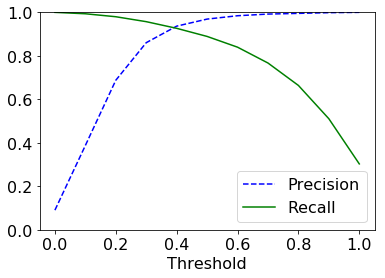

In [29]:
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(y_train_5, y_scores_forest)
plot_precision_recall_threshold(precisions_forest, recalls_forest, thresholds_forest)

In [30]:
y_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=5)
print('Precision %.3f, recall %.3f' % (precision_score(y_train_5, y_pred_forest), recall_score(y_train_5, y_pred_forest)))

Precision 0.984, recall 0.840


In [31]:
from sklearn.metrics import accuracy_score
forest_clf = RandomForestClassifier(random_state=42)
forest_clf.fit(X_train, y_train_5)
print('Accuracy %.3f' % accuracy_score(y_test_5, forest_clf.predict(X_test)))

Accuracy 0.984


### Compare to the AutoKeras result, just for fun. This could freeze your computer for a loooong time!

In [ ]:
from autokeras import ImageClassifier
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = X_train.reshape(x_train.shape + (1,))
x_test = X_test.reshape(x_test.shape + (1,))
print(x_train.shape)
print(x_test.shape)

clf = ImageClassifier(verbose=True)
# These are commented out as training could take a very long time
# clf.fit(x_train, y_train, time_limit=12 * 60 * 60)
# clf.final_fit(x_train, y_train, x_test, y_test, retrain=True)
# y = clf.evaluate(x_test, y_test)
# print(y)